# UNet

La red UNet es una red neuronal convolucional desarrollada para la segmentación de imágenes biomédicas que obtiene buenos resultados utilizando pocas imágenes de entrenamiento.

Para poder ejecutar este notebook es necesario que instales el framework torch y las librerías torchvision y glob. Por ejemplo, si usas pip, el comando que debes ejecutar para instalar esta librería es:

```
pip install torch torchvision glob
```

## Definición del problema
Tenemos que desarrollar un método para segmentar de forma automática embriones de ratón en imágenes de microscopio [__[fuente](https://bbbc.broadinstitute.org/BBBC003)__]. Para desarrollar el método disponemos de un conjunto de 15 imágenes con sus respectivas máscaras de segmentación manuales.

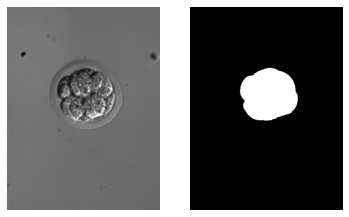

In [1]:
import matplotlib.pyplot as plt
import cv2

# Función auxiliar para mostrar a la vez una imagen
# y una máscara
def show(image, mask, title=None):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image, cmap="gray")
    ax[0].axis('off')
    if title is not None:
        fig.suptitle(title)
    ax[1].imshow(mask, cmap="gray")
    ax[1].axis('off')
    #ax[2].imshow(mask*im,cmap='gray')
    plt.show()
    

im = cv2.imread("res/unet/images/7_19_M1E18.tif", cv2.IMREAD_GRAYSCALE)
mask = cv2.imread("res/unet/masks/7_19_M1E18.tif", cv2.IMREAD_GRAYSCALE)
show(im,mask)




## Solución con redes UNet
Para abordar el problema utilizaremos una red de tipo UNet. Para ello es necesario seguir los siguientes pasos:

1. Definir la arquitectura de la red
2. Crear un conjunto de entrenamiento y otro de validación con las imágenes disponibles
3. Entrenar la red
4. Validar los resultados obtenidos

### Arquitectura
El siguiente código define una arquitectura sencilla de una red UNet [__[fuente](https://github.com/usuyama/pytorch-unet)__]. 

In [2]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, input_channels, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(input_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

## Conjunto de entrenamiento y validación
En este paso cargaremos las imágenes para crear los conjuntos de entrenamiento y validación.

La clase EmbryoDataset nos permitirá cargar las imágenes de una forma adecuada para realizar el entrenamiento en torch. Al crear esta clase podemos indicar transformaciones a aplicar en las imágenes (rotaciones, traslaciones, desenfoque, etc) para generar datos artificiales y así incrementar el número de ejemplos de nuestro conjunto de entrenamiento (data augmentation).


In [3]:
import torch.utils.data as data
import torchvision.transforms as transforms
import glob
import os
import numpy as np
import random


class EmbryoDataset(data.Dataset):
    
    def __init__(self, image_path, mask_path, transform = None):
        super().__init__()
        # Cargar los nombres de fichero de todas las imágenes
        self.img_files = glob.glob(os.path.join(image_path,'*.tif'))
        self.mask_files = []
        # Cargar los nombres de fichero de las máscaras (se asume cada
        # máscara tiene el mismo nombre que la imagen correspondiente)
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(mask_path,os.path.basename(img_path)))
                
        self.transform = transform

    # Devuelve la n-ésima imagen con su máscara correspondiente 
    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            if self.transform is not None:
                seed = np.random.randint(2147483647) # make a seed with numpy generator 
                random.seed(seed) # apply this seed to img tranfsorms
                torch.manual_seed(seed) 
                image = self.transform(image)
                random.seed(seed) # apply this seed to img tranfsorms
                torch.manual_seed(seed) 
                mask = self.transform(mask)
            else:
                t2 = transforms.Compose([ 
                        transforms.ToPILImage(),
                        transforms.ToTensor()])
                image = t2(image)
                mask = t2(mask)
                
                
            return image, mask

    def __len__(self):
        return len(self.img_files)

# Función auxiliar para convertir un tensor de torch en una matriz numpy
def tensor_to_image(tensor):
    new_image = np.empty( (tensor.size()[1], tensor.size()[2]) )
    new_image[:,:] = tensor[0,:,:]
    return new_image


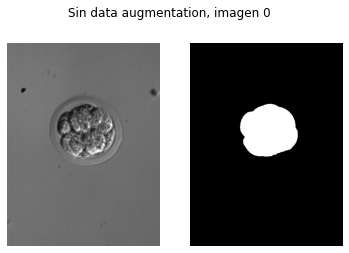

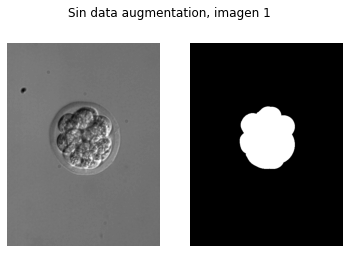

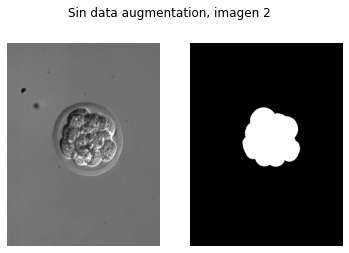

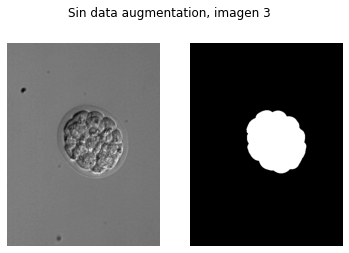

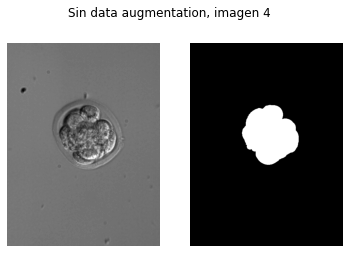

In [5]:
# Cargar imágenes del dataset sin data augmentation

simple_dataset = EmbryoDataset("res/unet/images", "res/unet/masks")
nsamples = 5
for i in range(nsamples):
    im, mask = simple_dataset[i]
    show(tensor_to_image(im), tensor_to_image(mask), title=f"Sin data augmentation, imagen {i}")
    

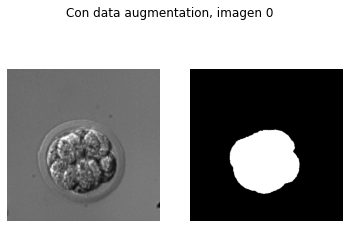

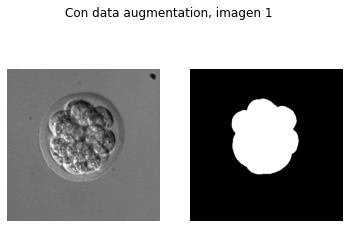

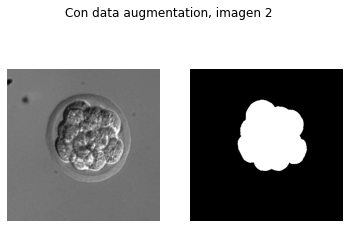

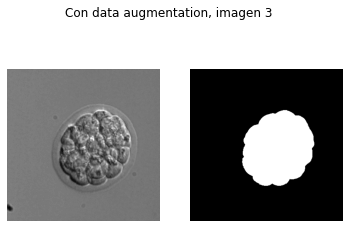

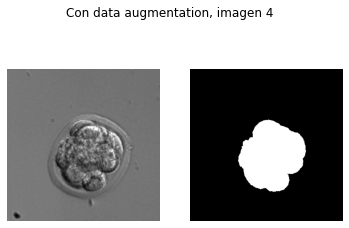

In [6]:
# Cargar imágenes con data augmentation
transf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(5),
        transforms.CenterCrop(400), # Evitar zonas negras tras rotar imagen
        transforms.ToTensor()
    ])


augmented_dataset = EmbryoDataset("res/unet/images", "res/unet/masks", transf)
for i in range(nsamples):
    im, mask = augmented_dataset[i]
    show(tensor_to_image(im), tensor_to_image(mask), title=f"Con data augmentation, imagen {i}")


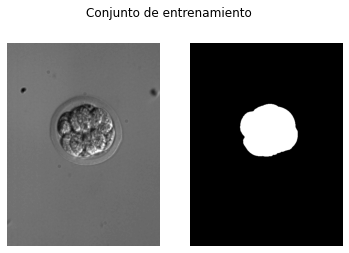

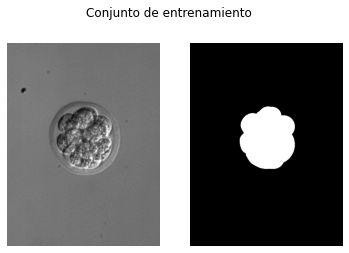

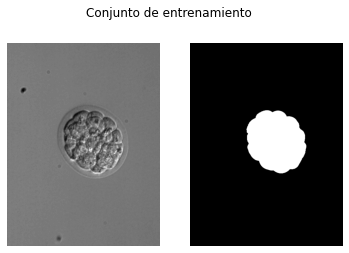

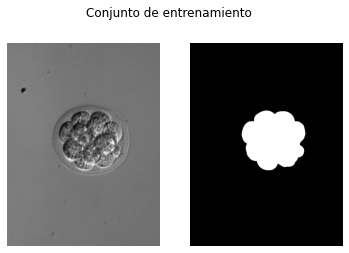

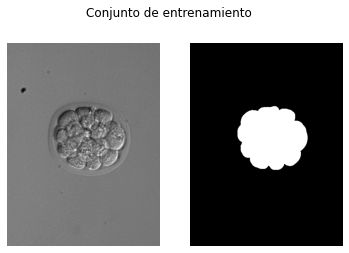

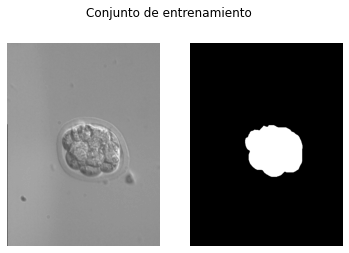

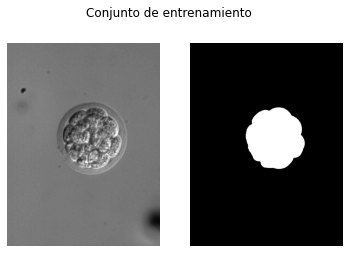

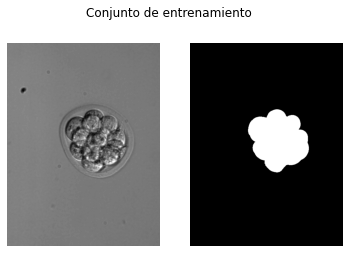

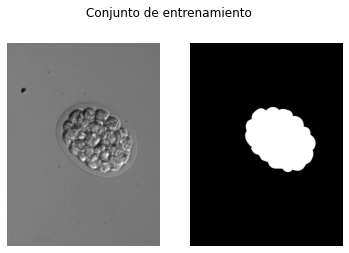

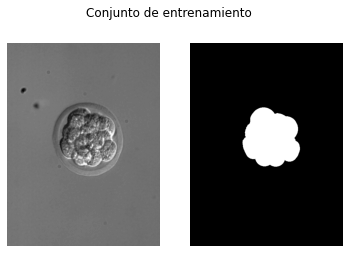

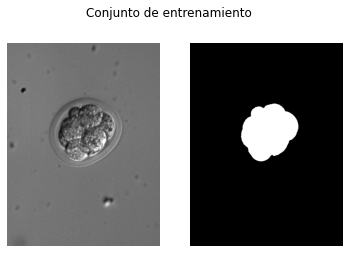

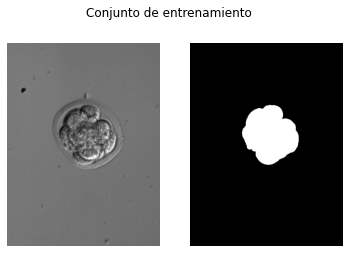

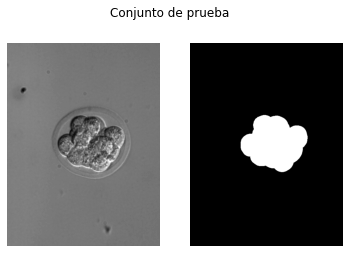

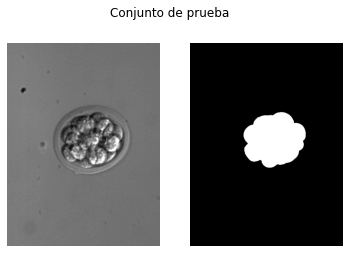

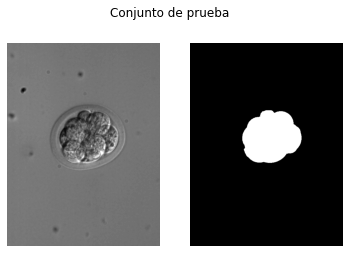

In [7]:
# Dividir las imágenes del conjunto de entrenamiento en entrenamiento 
# (12 imágenes) y prueba (3 imágenes)
train_set, test_set = torch.utils.data.random_split(simple_dataset, [12, 3])
for im, mask in train_set:
    show(tensor_to_image(im), tensor_to_image(mask), title="Conjunto de entrenamiento")
    
for im, mask in test_set:
    show(tensor_to_image(im), tensor_to_image(mask), title="Conjunto de prueba")
   

## Entrenamiento

Una vez creados los conjuntos de entrenamiento y prueba, se procede a entrenar la red. Dependiendo de las características del ordenador puede tardar un poco.

In [7]:
# Definir hiperparámetros
BATCH_SIZE = 2
LR = 0.0001
N_INPUT_CHANNELS = 1
N_CLASSES = 1
THRESHOLD = 0.5

In [8]:
# Definición de variables

# Iteradores sobre los conjuntos de entrenamiento y prueba
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False)

# Red
unet = UNet(N_INPUT_CHANNELS,N_CLASSES)

# Métrica a minimizar
bce_loss = nn.BCEWithLogitsLoss()

# Algoritmo de minimización
adam_optimizer = torch.optim.Adam(unet.parameters(), lr=LR)


from time import process_time

# Función de entrenamiento
def train(net, train_loader, test_loader, criterion, optimizer, nepochs=10):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    net = net.to(device)
    
    train_steps = len(train_loader)
    test_steps = len(test_loader)
    best_loss = 9999999
    
    for epoch in range(nepochs):  # entrenar nepochs veces
        t1_start = process_time()
        
        net.train() # Modo entrenamiento
        total_train_loss = 0
        total_test_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            # tomar los datos para entrenar la red
            inputs, masks = data
            inputs = inputs.to(device)
            masks = masks.to(device)

            # inicializar a cero los gradientes de los parámetros
            optimizer.zero_grad()

            # pasar los datos a la red, comprobar el error
            # y recalcular los parámetros en base al error
            outputs = net(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            # estadísticas
            total_train_loss += loss.item()
            
        with torch.no_grad():
            net.eval() # modo evaluación
            # calcular el error en conjunto de test
            for (inputs, masks) in test_loader:
                inputs = inputs.to(device)
                masks = masks.to(device)
                outputs = net(inputs)
                total_test_loss += criterion(outputs, masks)
        
        
        avg_test_loss = total_test_loss/test_steps
        # guardar la mejor red
        if  avg_test_loss < best_loss:
            best_loss =  avg_test_loss
            torch.save(unet, 'unet-best.pth') 
        t1_stop = process_time()
        
        print(f"[INFO] EPOCH {epoch}/{nepochs} Train loss: {total_train_loss/train_steps} Test loss: {total_test_loss/test_steps} Elapsed time: {t1_stop-t1_start}s")
    print('Finished Training. Saving final model...')
    torch.save(unet, 'unet-final.pth')


In [9]:
#%%timeit

# Llamada a la función de entrenamiento
train(unet, train_loader, test_loader, bce_loss, adam_optimizer, 30)

[INFO] EPOCH 0/30 Train loss: 0.6478857696056366 Test loss: 0.6441340446472168 Elapsed time: 3.1235560100000015s
[INFO] EPOCH 1/30 Train loss: 0.6344372630119324 Test loss: 0.6177912950515747 Elapsed time: 2.6725684560000005s
[INFO] EPOCH 2/30 Train loss: 0.5171064684788386 Test loss: 0.3424534797668457 Elapsed time: 2.369410069999999s
[INFO] EPOCH 3/30 Train loss: 0.34079556663831073 Test loss: 0.3528062105178833 Elapsed time: 2.7743327099999995s
[INFO] EPOCH 4/30 Train loss: 0.3281762848297755 Test loss: 0.3420572280883789 Elapsed time: 3.0813609720000024s
[INFO] EPOCH 5/30 Train loss: 0.3063022941350937 Test loss: 0.3356107473373413 Elapsed time: 3.105868632s
[INFO] EPOCH 6/30 Train loss: 0.2987570067246755 Test loss: 0.33782169222831726 Elapsed time: 3.040811551000001s
[INFO] EPOCH 7/30 Train loss: 0.294881006081899 Test loss: 0.332448810338974 Elapsed time: 3.111879798000004s
[INFO] EPOCH 8/30 Train loss: 0.29218638439973194 Test loss: 0.3306506276130676 Elapsed time: 3.1119240220

## Validar los resultados obtenidos

Tras el entrenamiento podemos utilizar nuestra red para segmentar nuevas imágenes.

In [10]:
# Función para realizar predicciones a partir de imágenes
def predict(net, image, threshold=0.5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():
        net.eval()    
        image = image.to(device)
        output = net(image)
        prob = torch.sigmoid(output)
        prediction = tensor_to_image(prob[0,:,:,:].detach().cpu()>threshold)
        return prediction



## MEDIDA ESTADÍSTICA SIN DATA AUGMENTATION:

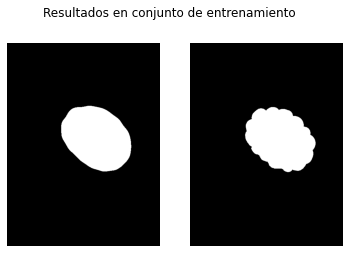

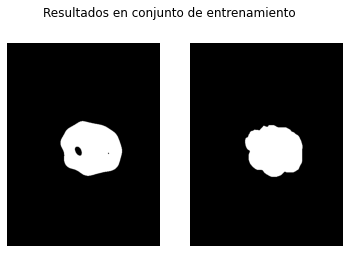

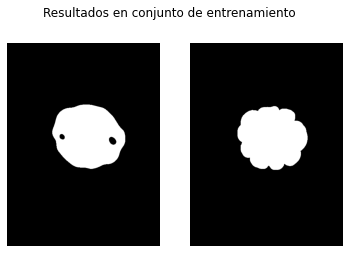

La sensibilidad alcanzada con la red en el conjunto de test es de: 0.9711915704517431


In [11]:
unet = torch.load('unet-best.pth', map_location=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

# Planteamos unos arrays para almacenar los verdaderos positivos (VP) y falsos negativos (FN) que se determinen. 
# Los verdaderos positivos serán aquellos píxeles que están presentes en el solapamiento de la segmentación manual y la del algoritmo
# En cambio, los falsos negativos serán los presentes en la diferencia de la segmentación manual y el solapamiento.
# Siguiendo procedimientos vistos en los jupyter notebook 8 y 9, se plantea lo siguiente:

VP = []
FN = []


for im, mask in test_set:
    im = im[None, :,:,:]
    prediction = predict(unet, im)
    show (prediction, tensor_to_image(mask), title="Resultados en conjunto de entrenamiento")
    región_manual = (tensor_to_image(mask) == 1) # Región con la segmentación manual
    región_auto = (prediction == 1) # Región alcanzada mediante el algoritmo utilizado
    overlap = región_manual * región_auto # Coincidencia entre la segmentación manual y con el algoritmo
    px_overlap = np.sum(overlap) # Píxeles presentes en la coincidencia
    no_overlap = región_manual ^ overlap # Resultado de la diferencia de segmentación manual y la coincidencia
    px_no_overlap = np.sum(no_overlap)
    VP.append(px_overlap)
    FN.append(px_no_overlap)

sensitivity = np.mean(VP) / (np.mean(VP) + np.mean(FN))
print('La sensibilidad alcanzada con la red en el conjunto de test es de:', sensitivity)

### Ejercicio

Entrena la red con data augmentation y sin data augmentation y realiza una validación estadística en el conjunto de test de los resultados del entrenamiento.

## ENTRENAMIENTO DE LA RED CON DATA AUGMENTATION:

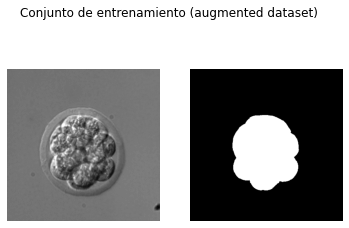

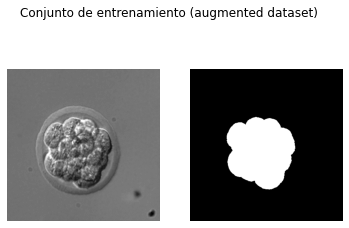

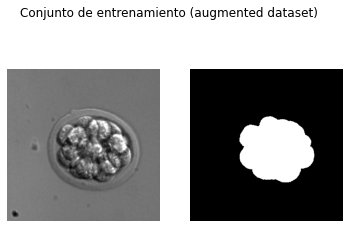

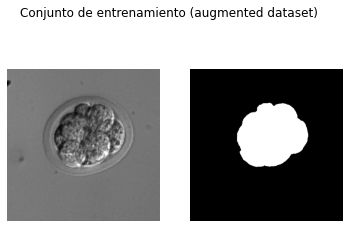

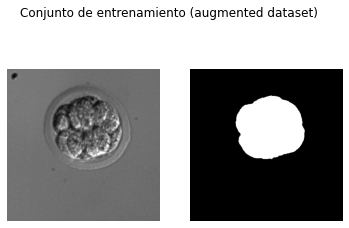

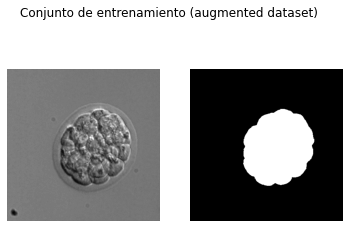

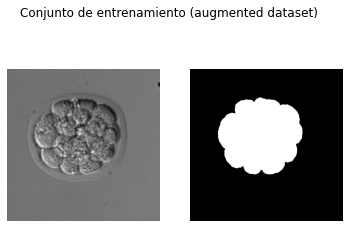

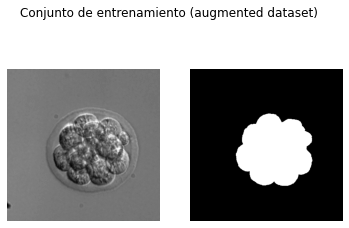

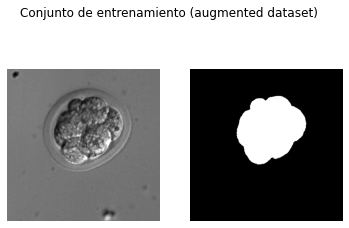

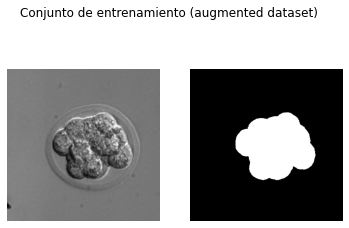

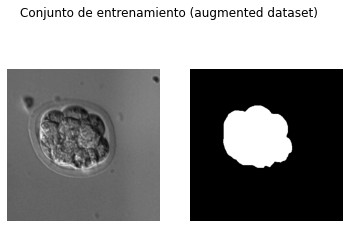

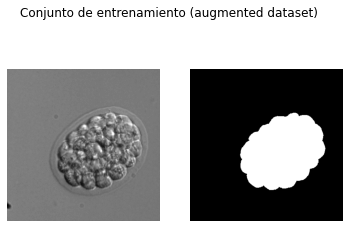

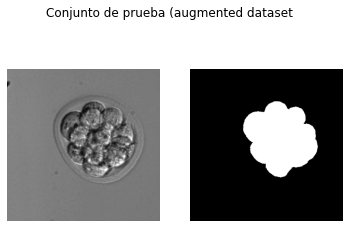

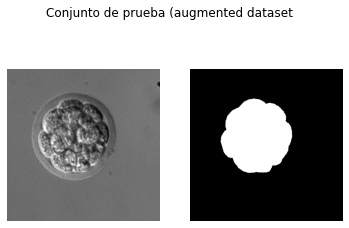

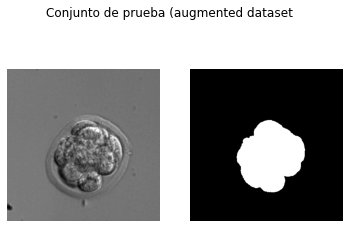

In [8]:
# Entrenamiento de la red con data augmentation:

# Dividir las imágenes del conjunto de entrenamiento en entrenamiento 
# (12 imágenes) y prueba (3 imágenes)
train_set, test_set = torch.utils.data.random_split(augmented_dataset, [12, 3])
for im, mask in train_set:
    show(tensor_to_image(im), tensor_to_image(mask), title="Conjunto de entrenamiento (augmented dataset)")
    
for im, mask in test_set:
    show(tensor_to_image(im), tensor_to_image(mask), title="Conjunto de prueba (augmented dataset")


In [9]:
# ENTRENAMIENTO:
# Se definen hiperparámetros:
BATCH_SIZE = 2
LR = 0.0001
N_INPUT_CHANNELS = 1
N_CLASSES = 1
THRESHOLD = 0.5

# Definición de variables

# Iteradores sobre los conjuntos de entrenamiento y prueba
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False)

# Red
unet = UNet(N_INPUT_CHANNELS,N_CLASSES)

# Métrica a minimizar
bce_loss = nn.BCEWithLogitsLoss()

# Algoritmo de minimización
adam_optimizer = torch.optim.Adam(unet.parameters(), lr=LR)


from time import process_time

# Función de entrenamiento
def train(net, train_loader, test_loader, criterion, optimizer, nepochs=10):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    net = net.to(device)
    
    train_steps = len(train_loader)
    test_steps = len(test_loader)
    best_loss = 9999999
    
    for epoch in range(nepochs):  # entrenar nepochs veces
        t1_start = process_time()
        
        net.train() # Modo entrenamiento
        total_train_loss = 0
        total_test_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            # tomar los datos para entrenar la red
            inputs, masks = data
            inputs = inputs.to(device)
            masks = masks.to(device)

            # inicializar a cero los gradientes de los parámetros
            optimizer.zero_grad()

            # pasar los datos a la red, comprobar el error
            # y recalcular los parámetros en base al error
            outputs = net(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            # estadísticas
            total_train_loss += loss.item()
            
        with torch.no_grad():
            net.eval() # modo evaluación
            # calcular el error en conjunto de test
            for (inputs, masks) in test_loader:
                inputs = inputs.to(device)
                masks = masks.to(device)
                outputs = net(inputs)
                total_test_loss += criterion(outputs, masks)
        
        
        avg_test_loss = total_test_loss/test_steps
        # guardar la mejor red
        if  avg_test_loss < best_loss:
            best_loss =  avg_test_loss
            torch.save(unet, 'unet-best.pth') 
        t1_stop = process_time()
        
        print(f"[INFO] EPOCH {epoch}/{nepochs} Train loss: {total_train_loss/train_steps} Test loss: {total_test_loss/test_steps} Elapsed time: {t1_stop-t1_start}s")
    print('Finished Training. Saving final model...')
    torch.save(unet, 'unet-final.pth')



In [10]:
# Llamada a la función de entrenamiento
train(unet, train_loader, test_loader, bce_loss, adam_optimizer, 30)

[INFO] EPOCH 0/30 Train loss: 0.7126524845759074 Test loss: 0.7073709964752197 Elapsed time: 1.7748765740000003s
[INFO] EPOCH 1/30 Train loss: 0.6990877091884613 Test loss: 0.6747721433639526 Elapsed time: 1.6560097559999996s
[INFO] EPOCH 2/30 Train loss: 0.5896251002947489 Test loss: 0.49922114610671997 Elapsed time: 1.662896109s
[INFO] EPOCH 3/30 Train loss: 0.48710820575555164 Test loss: 0.47709921002388 Elapsed time: 1.683731593000001s
[INFO] EPOCH 4/30 Train loss: 0.47626719375451404 Test loss: 0.4522600471973419 Elapsed time: 1.669672974000001s
[INFO] EPOCH 5/30 Train loss: 0.4691070268551509 Test loss: 0.44805166125297546 Elapsed time: 1.6738263550000028s
[INFO] EPOCH 6/30 Train loss: 0.4636116524537404 Test loss: 0.44638878107070923 Elapsed time: 1.6839322950000017s
[INFO] EPOCH 7/30 Train loss: 0.4625611901283264 Test loss: 0.4425761103630066 Elapsed time: 1.6869252780000004s
[INFO] EPOCH 8/30 Train loss: 0.45556527376174927 Test loss: 0.43610745668411255 Elapsed time: 1.69264

In [11]:
# Validación de los resultados alcanzados:
# Función para realizar predicciones a partir de imágenes
def predict(net, image, threshold=0.5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():
        net.eval()    
        image = image.to(device)
        output = net(image)
        prob = torch.sigmoid(output)
        prediction = tensor_to_image(prob[0,:,:,:].detach().cpu()>threshold)
        return prediction

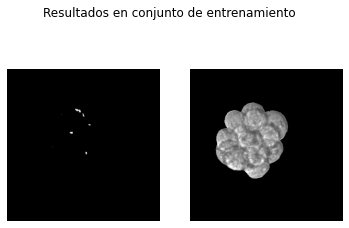

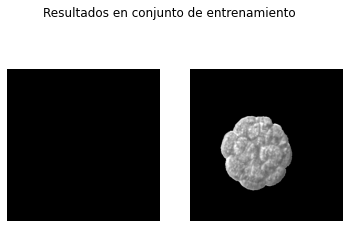

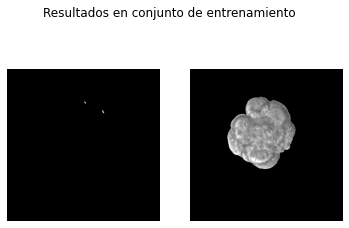

In [12]:
unet = torch.load('unet-best.pth', map_location=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

for im, mask in test_set:
    im = im[None, :,:,:]
    prediction = predict(unet, im)
    show(tensor_to_image(im[0,:,:,:])*prediction, tensor_to_image(im[0,:,:,:])*tensor_to_image(mask), title="Resultados en conjunto de entrenamiento")

## MEDIDA ESTADÍSTICA CON DATA AUGMENTATION:

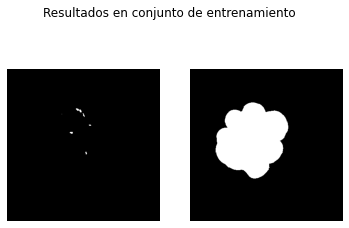

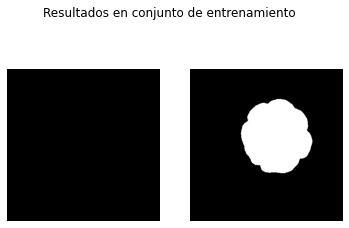

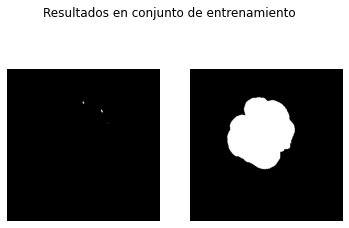

La sensibilidad alcanzada con la red en el conjunto de test es de: 0.0026924027418284927


In [13]:
unet = torch.load('unet-best.pth', map_location=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

VP = []
FN = []


for im, mask in test_set:
    im = im[None, :,:,:]
    prediction = predict(unet, im)
    show (prediction, tensor_to_image(mask), title="Resultados en conjunto de entrenamiento")
    región_manual = (tensor_to_image(mask) == 1) # Región con la segmentación manual
    región_auto = (prediction == 1) # Región alcanzada mediante el algoritmo utilizado
    overlap = región_manual * región_auto # Coincidencia entre la segmentación manual y con el algoritmo
    px_overlap = np.sum(overlap) # Píxeles presentes en la coincidencia
    no_overlap = región_manual ^ overlap # Resultado de la diferencia de segmentación manual y la coincidencia
    px_no_overlap = np.sum(no_overlap)
    VP.append(px_overlap)
    FN.append(px_no_overlap)

sensitivity = np.mean(VP) / (np.mean(VP) + np.mean(FN))
print('La sensibilidad alcanzada con la red en el conjunto de test es de:', sensitivity)